<a href="https://colab.research.google.com/github/charlesdgburns/maze_grid_cells/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting off. We want to get familiar with the networkx package.

# Representations.py

A simplified approach will be to look at eigenvectors of place cells. This would be similar to the eigenvector of the state transition matrix.

In [2]:
# %% Imports
import json
import numpy as np
import networkx as nx

# %% Define global varaibles from experiment_info.json
with open("experiment_info.json") as input_file:
    exp_info = json.load(input_file)

MAZE_NODE_DIMENSIONS = tuple(exp_info["maze_measurements"]["maze_node_dimensions"])
LOWER_LEFT = exp_info["maze_measurements"]["lower_left_node_cartesian_center"]  # meters
DISTANCE_BETWEEN_TOWERS = exp_info["maze_measurements"]["distance_between_node_centers"]  # meters
TOWER_WIDTH = exp_info["maze_measurements"]["tower_width"]  # meters


Below we copypaste representations.py

In [3]:

# %% Imports
import json
import numpy as np
import networkx as nx

# %% Define global varaibles from experiment_info.json
with open("experiment_info.json") as input_file:
    exp_info = json.load(input_file)

MAZE_NODE_DIMENSIONS = tuple(exp_info["maze_measurements"]["maze_node_dimensions"])
LOWER_LEFT = exp_info["maze_measurements"]["lower_left_node_cartesian_center"]  # meters
DISTANCE_BETWEEN_TOWERS = exp_info["maze_measurements"]["distance_between_node_centers"]  # meters
TOWER_WIDTH = exp_info["maze_measurements"]["tower_width"]  # meters

# %% Useful analysis functions


def get_extended_simple_maze(simple_maze):
    """"""
    edge_graph = nx.line_graph(simple_maze)
    extended_simple_maze = nx.Graph()
    extended_node2position = {
        **nx.get_node_attributes(simple_maze, "position"),
        **nx.get_edge_attributes(simple_maze, "position"),
    }
    extended_node2label = {
        **nx.get_node_attributes(simple_maze, "label"),
        **nx.get_edge_attributes(simple_maze, "label"),
    }
    extended_simple_maze.add_nodes_from(simple_maze.nodes)
    extended_simple_maze.add_nodes_from(edge_graph.nodes)
    nx.set_node_attributes(extended_simple_maze, extended_node2position, "position")
    nx.set_node_attributes(extended_simple_maze, extended_node2label, "label")
    for edge_node in edge_graph:
        extended_simple_maze.add_edge(edge_node[0], edge_node)
        extended_simple_maze.add_edge(edge_node, edge_node[1])
    # add edge labels
    extended_edge2label = {
        edge: tuple([extended_node2label[p] for p in edge]) for edge in extended_simple_maze.edges()
    }
    nx.set_edge_attributes(extended_simple_maze, extended_edge2label, "label")
    return extended_simple_maze


def get_maze_locations(simple_maze, edges_only=False, nodes_only=False):
    node_coord2label = nx.get_node_attributes(simple_maze, "label")
    edge_coord2label = nx.get_edge_attributes(simple_maze, "label")
    if nodes_only:
        return [node_coord2label[n] for n in simple_maze.nodes]
    if edges_only:
        return [edge_coord2label[e] for e in simple_maze.edges]
    return [node_coord2label[n] for n in simple_maze.nodes] + [edge_coord2label[e] for e in simple_maze.edges]


def get_maze_place_direction_pairs(simple_maze):
    node_coord2label = nx.get_node_attributes(simple_maze, "label")
    edge_coord2label = nx.get_edge_attributes(simple_maze, "label")
    location_action_pairs = []
    for node in simple_maze.nodes:
        neighbors = list(simple_maze.neighbors(node))
        for neighbor in neighbors:
            if neighbor[0] == node[0] + 1:
                direction = "E"
            elif neighbor[0] == node[0] - 1:
                direction = "W"
            elif neighbor[1] == node[1] + 1:
                direction = "N"
            elif neighbor[1] == node[1] - 1:
                direction = "S"
            location_action_pairs.append((node_coord2label[node], direction))
    for edge in simple_maze.edges:
        node1, node2 = edge
        if node1[0] == (node2[0] + 1) or node1[0] == (node2[0] - 1):
            directions = ["E", "W"]
        elif node1[1] == (node2[1] + 1) or node1[1] == (node2[1] - 1):
            directions = ["N", "S"]
        location_action_pairs.append((edge_coord2label[edge], directions[0]))
        location_action_pairs.append((edge_coord2label[edge], directions[1]))
    return location_action_pairs


def get_maze_location2NSEW(simple_maze):
    node_coord2label = nx.get_node_attributes(simple_maze, "label")
    edge_coord2label = nx.get_edge_attributes(simple_maze, "label")
    location2NSEW = {}
    for node in simple_maze.nodes:
        neighbors = list(simple_maze.neighbors(node))
        node_neighbors_NSEW = []
        for neighbor in neighbors:
            if neighbor[0] == node[0] + 1:
                node_neighbors_NSEW.append("E")
            elif neighbor[0] == node[0] - 1:
                node_neighbors_NSEW.append("W")
            elif neighbor[1] == node[1] + 1:
                node_neighbors_NSEW.append("N")
            elif neighbor[1] == node[1] - 1:
                node_neighbors_NSEW.append("S")
        location2NSEW[node_coord2label[node]] = node_neighbors_NSEW
    for edge in simple_maze.edges:
        node1, node2 = edge
        edge_neighbors_NSEW = []
        if node1[0] == (node2[0] + 1) or node1[0] == (node2[0] - 1):
            edge_neighbors_NSEW.append("E")
            edge_neighbors_NSEW.append("W")
        elif node1[1] == (node2[1] + 1) or node1[1] == (node2[1] - 1):
            edge_neighbors_NSEW.append("N")
            edge_neighbors_NSEW.append("S")
        location2NSEW[edge_coord2label[edge]] = edge_neighbors_NSEW
    return location2NSEW


def get_simple_maze(maze_number):
    edges = exp_info["maze_config2info"][f"maze_{maze_number}"]["structure"]
    return simple_maze(edges)


def get_maze_label2coord(simple_maze):
    """
    Returns a dictionary of node and edge labels (same as label attributes in simple maze object) to coordinates
    (network x node and edge positions).
    """
    node_coord2label = get_maze_coord2label(simple_maze)
    return {v: k for k, v in node_coord2label.items()}


def get_maze_coord2label(simple_maze):
    """
    Returns a dictionary of node and edge coordinates (network x node and edge positions) to
    standard alpha-neumeric labels
    """
    node_coord2label = nx.get_node_attributes(simple_maze, "label")
    edge_coord2label = nx.get_edge_attributes(simple_maze, "label")
    return {**node_coord2label, **edge_coord2label}


# %%


def simple_maze(edges):
    """
    Creates a networkx graph representation of a maze, where nodes are towers, and edges are walkways
    Input: edges (list of str): list of edges in the maze, in the format 'A1-A2'
    Output: maze (networkx graph): graph representation of the maze
    """
    maze = nx.Graph()
    maze.add_nodes_from(nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).nodes())
    edge_coords = get_edge_coords(edges)
    maze.add_weighted_edges_from([i + (DISTANCE_BETWEEN_TOWERS,) for i in edge_coords])
    nx.set_node_attributes(maze, _get_node_positions_dict(), "position")
    nx.set_node_attributes(maze, {v: k for k, v in get_simple_nodes_dict().items()}, "label")
    nx.set_edge_attributes(maze, {key: _get_center_edge_positions_dict()[key] for key in edge_coords}, "position")
    nx.set_edge_attributes(maze, {key: get_edge_coords2label_dict()[key] for key in edge_coords}, "label")
    return maze


def skeleton_maze(edges):
    """
    Creates a networkx graph representation of a maze, where towers are discritsed into 5 nodes, and walkways are
    discrised into 3 nodes
    Input: edges (list of str): list of edges in the maze, in the format 'A1-A2'
    Output: maze (networkx graph): graph representation of the maze
    Notes:
        - Tower nodes are represented by their discrete coordinates on the simple maze with an additional dimension
        representing their place in the tower: eg, (0,0,0) is the center node in the tower at (0,0). Explicitly:
        (.,.,0) = 'center', (.,.,1) = 'top-left', (.,.,2) = 'top-right', (.,.,3) = 'bottom-left',
        (.,.,4) = 'bottom-right'
        - Edge nodes are represented by their discrete edge coordinates on the simple maze with an additional dimension
        representing their place between adjacent nodes, this is separate for horizontal and vertical edges:
        - Horizontal edges: ((.,.),(.,.),0) = 'west', ((.,.),(.,.),1) = 'middle', (.,.),(.,.),2) = 'east'
        - Vertical edges: ((.,.),(.,.),0) = 'south', ((.,.),(.,.),1) = 'middle', (.,.),(.,.),2) = 'north'
        - Positions (x,y: cartesian coordinates) and labels are attributed to each node
    """
    skeleton_maze = nx.Graph()
    edges = get_edge_coords(edges)
    skeleton_maze_nodes = get_skeleton_maze_nodes(edges)
    skeleton_maze.add_nodes_from(skeleton_maze_nodes)
    skeleton_maze_weighted_edges = _get_skeleton_maze_weighted_edges(edges)
    skeleton_maze.add_weighted_edges_from(skeleton_maze_weighted_edges)
    skeleton_node2position = {
        k: v for k, v in get_skeleton_maze_node_positions_dict().items() if k in skeleton_maze_nodes
    }
    skeleton_node2label = {k: v for k, v in get_skeleton_maze_node_labels_dict().items() if k in skeleton_maze_nodes}
    nx.set_node_attributes(skeleton_maze, skeleton_node2position, "position")
    nx.set_node_attributes(skeleton_maze, skeleton_node2label, "label")
    return skeleton_maze


# %% Simple maze functions


def _get_letter_codes(n):
    """Returns a list of n capital letters of the alphabet"""
    return [chr(i) for i in range(65, 65 + n)]


def get_simple_nodes_dict():
    """Returns a dictionary of alphanumeric nodes ('A1') to simple maze node coordinates (0,0)"""
    nodes_letter2coord = {}
    letter_codes = _get_letter_codes(MAZE_NODE_DIMENSIONS[1])
    for i, l in enumerate(letter_codes):
        for j in np.arange(0, MAZE_NODE_DIMENSIONS[0]):
            letter_node = l + str(j + 1)
            coord_node = (i, j)
            nodes_letter2coord[letter_node] = coord_node
    return nodes_letter2coord


def convert_labels_to_coords(nodes):
    """converts a list of alphanumeric nodes ('A1') to simple maze coordinates (0,0)"""
    nodes_dict = get_simple_nodes_dict()
    nodes_coord = []
    for n in nodes:
        nodes_coord.append(nodes_dict[n])
    return nodes_coord


def get_edge_coords(edges):
    """converts a list of alphanumeric edges ('A1-A2') to simple maze coordinates ((0,0),(0,1))"""
    nodes_dict = get_simple_nodes_dict()
    edges_letter_tuple = [edge.split("-") for edge in edges]
    edge_coords = []
    for i, edge in enumerate(edges_letter_tuple):
        edge_coords.append((nodes_dict[edge[0]], nodes_dict[edge[1]]))
    return edge_coords


def get_edge_coords2label_dict():
    """Returns a dictionary of edge coordinates ((0,0),(0,1)) to alphanumeric edge labels ('A1-A2')"""
    all_edges = nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).edges()
    node_coord2label = {v: k for k, v in get_simple_nodes_dict().items()}
    edge_coords2label = {}
    for edge in all_edges:
        edge_coords2label[edge] = node_coord2label[edge[0]] + "-" + node_coord2label[edge[1]]
    return edge_coords2label


def _get_node_positions_dict():
    """Returns a dictionary of node positions to cartesian coordinates, defined as center of maze tower"""
    nodes_dict = get_simple_nodes_dict()
    discrete_nodes2cartesian_nodes = {}
    node_discrete_coords = nodes_dict.values()
    for discrete_x, discrete_y in node_discrete_coords:
        cartesian_x = discrete_x * DISTANCE_BETWEEN_TOWERS + LOWER_LEFT[0]
        cartesian_y = discrete_y * DISTANCE_BETWEEN_TOWERS + LOWER_LEFT[1]
        discrete_nodes2cartesian_nodes[(discrete_x, discrete_y)] = (cartesian_x, cartesian_y)
    return discrete_nodes2cartesian_nodes


def _split_edges_into_horizontal_vertical(edges):
    """Splits a list of edge coors into horizontal and vertical edges (separate list outputs as tuple)"""
    horizontal_edges = []
    vertical_edges = []
    for edge in edges:
        if edge[0][0] == edge[1][0]:
            vertical_edges.append(edge)
        elif edge[0][1] == edge[1][1]:
            horizontal_edges.append(edge)
    return horizontal_edges, vertical_edges


def _get_center_edge_positions_dict():
    """Returns a dictionary of edge positions to cartesian coordinates"""
    center_edge_positions = {}
    all_edges = nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).edges()
    node_positions = _get_node_positions_dict()
    # sort edge coords into horizontal and vertical edges
    horizontal_edges, vertical_edges = _split_edges_into_horizontal_vertical(all_edges)
    # get center positions of horizontal edges
    for edge in horizontal_edges:
        node1, node2 = edge
        x1, y1 = node_positions[node1]
        x2, y2 = node_positions[node2]
        x = (x1 + x2) / 2
        y = y1
        center_edge_positions[edge] = (x, y)
    # get center positions of vertical edges
    for edge in vertical_edges:
        node1, node2 = edge
        x1, y1 = node_positions[node1]
        x2, y2 = node_positions[node2]
        x = x1
        y = (y1 + y2) / 2
        center_edge_positions[edge] = (x, y)
    return center_edge_positions


# %% skeleton maze functions


def _get_skeleton_tower_nodes():
    """
    Returns a list of nodes for the skeleton maze that define a maze tower and cover the same space as a single node
    in the simple maze.
        - Coordinates are defined similar to the simple maze, but with an additional z coordinate to represent relative position
          from the center of the tower: (.,.,0) = 'center', (.,.,1) = 'top-left', (.,.,2) = 'top-right', (.,.,3) = 'bottom-left',
          (.,.,4) = 'bottom-right'
    """
    skeleton_tower_nodes = []
    for node in nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).nodes():
        tower_nodes = []
        for i in range(5):
            tower_nodes.append(node + (i,))
        skeleton_tfower_nodes.extend(tower_nodes)
    return skeleton_tower_nodes


def _get_skeleton_bridge_nodes(edges):
    """
    Returns a list of nodes for the skeleton maze that define a maze bridge and cover the same space as a single edge in the
    simple maze. Coordinates are defined similar to the simple maze, but with an additional z coordinate to represent relative
    position from the center of the bridge, separately for horizontal and vertical bridges:
        - Horizontal edges: ((.,.),(.,.),0) = 'west', ((.,.),(.,.),1) = 'middle', (.,.),(.,.),2) = 'east'
        - Vertical edges: ((.,.),(.,.),0) = 'south', ((.,.),(.,.),1) = 'middle', (.,.),(.,.),2) = 'north'
    """
    skeleton_bridge_nodes = []
    for edge in edges:
        bridge_nodes = []
        for i in range(3):
            bridge_nodes.append(edge + (i,))
        skeleton_bridge_nodes.extend(bridge_nodes)
    return skeleton_bridge_nodes


def get_skeleton_maze_nodes(edges):
    """Generates all the nodes for the skeleton maze from a list of edge coordinates"""
    skeleton_tower_nodes = _get_skeleton_tower_nodes()
    skeleton_bridge_nodes = _get_skeleton_bridge_nodes(edges)
    skeleton_maze_nodes = skeleton_tower_nodes + skeleton_bridge_nodes
    return skeleton_maze_nodes


def _get_skeleton_tower_edges():
    """Makes a list of edges on the nodes in the tower postions on the skeleton maze. In a tower, the center node is connected
    to the outer nodes in a diagonal pattern, and the outer nodes are connected to each other in a square pattern."""
    simple_maze_nodes = nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).nodes()
    skeleton_tower_edges = []
    for node in simple_maze_nodes:
        tower_edges = []
        # define diagonal connections:
        for i in np.arange(1, 5):
            center_node = node + (0,)
            outer_node = node + (i,)
            edge = (center_node, outer_node)
            tower_edges.append(edge)
        # define outer connections:
        for i, j in [(1, 2), (3, 4), (3, 1), (4, 2)]:
            tower_edges.append((node + (i,), node + (j,)))
        skeleton_tower_edges.extend(tower_edges)
    return skeleton_tower_edges


def _get_skeleton_bridge_edges(edges):
    """Makes a list of edges on the nodes in the bridge postions on the skeleton maze, defined differently for horizontal and
    vertical bridges. Horizontal node 0s are connected on the the 2nd and 4th nodes of towers to the west and horizontal node
    2s are connected to the 1st and 3rd towers to the east. The middle horixontal node (1) is connected to horizontal nodes 0
    and 2. The same logical applies for connections that make up vertical edges on the maze."""
    skeleton_bridge_edges = []
    horizontal_edges, vertical_edges = _split_edges_into_horizontal_vertical(edges)
    bridge_edges = []
    for edge in horizontal_edges:
        west_tower = edge[0]
        east_tower = edge[1]
        # west edges
        bridge_edges.append((west_tower + (0,), edge + (0,)))
        bridge_edges.append((west_tower + (2,), edge + (0,)))
        bridge_edges.append((west_tower + (4,), edge + (0,)))
        # middle edges
        bridge_edges.append((edge + (0,), edge + (1,)))
        bridge_edges.append((edge + (1,), edge + (2,)))
        # east edges
        bridge_edges.append((edge + (2,), east_tower + (0,)))
        bridge_edges.append((edge + (2,), east_tower + (1,)))
        bridge_edges.append((edge + (2,), east_tower + (3,)))
    skeleton_bridge_edges.extend(bridge_edges)
    bridge_edges = []
    for edge in vertical_edges:
        south_tower = edge[0]
        north_tower = edge[1]
        # south edges
        bridge_edges.append((south_tower + (0,), edge + (0,)))
        bridge_edges.append((south_tower + (1,), edge + (0,)))
        bridge_edges.append((south_tower + (2,), edge + (0,)))
        # middle edges
        bridge_edges.append((edge + (0,), edge + (1,)))
        bridge_edges.append((edge + (1,), edge + (2,)))
        # north edges
        bridge_edges.append((edge + (2,), north_tower + (0,)))
        bridge_edges.append((edge + (2,), north_tower + (3,)))
        bridge_edges.append((edge + (2,), north_tower + (4,)))
    skeleton_bridge_edges.extend(bridge_edges)
    return skeleton_bridge_edges


def get_skeleton_maze_edges(edges):
    """Generates all the edges for the skeleton maze from a list of edge coordinates"""
    skeleton_tower_edges = _get_skeleton_tower_edges()
    skeleton_bridge_edges = _get_skeleton_bridge_edges(edges)
    skeleton_maze_edges = skeleton_tower_edges + skeleton_bridge_edges
    return skeleton_maze_edges


# %%
def tower_apothem():
    """Calculates the apothem of a regular octagon given TOWER_WIDTH"""
    # see https://en.wikipedia.org/wiki/Apothem
    return TOWER_WIDTH / 2


def _get_skeleton_tower_positions_dict():
    """Makes a dictionary of the positions of the nodes in the tower postions on the skeleton maze. In a tower, the center node
    lies at the center of the tower, and the outer nodes lie on the corners of a square inscribed with the the octagonal towers.
    """
    apothem = tower_apothem()  # define distance beween center and outer tower nodes as apothem
    skeleton_tower_positions = {}
    tower2position = _get_node_positions_dict()
    for node in tower2position.keys():
        x, y = tower2position[node]
        skeleton_tower_positions[node + (0,)] = (x, y)
        skeleton_tower_positions[node + (1,)] = ((x - apothem / np.sqrt(2)), y + apothem / np.sqrt(2))
        skeleton_tower_positions[node + (2,)] = ((x + apothem / np.sqrt(2)), y + apothem / np.sqrt(2))
        skeleton_tower_positions[node + (3,)] = ((x - apothem / np.sqrt(2)), y - apothem / np.sqrt(2))
        skeleton_tower_positions[node + (4,)] = ((x + apothem / np.sqrt(2)), y - apothem / np.sqrt(2))
    return skeleton_tower_positions


def _get_skeleton_bridge_positions_dict():
    """Makes a dictionary of the positions of the nodes in the bridge postions on the skeleton maze, defined differently for horizontal and
    vertical bridges. North, south, east and west bridge nodes lie on the edge of the octagonal towers, and the middle bridge nodes lie
    half way between the center of adjacent towers."""
    skeleton_bridge_positions = {}
    bridge_node_spacing = DISTANCE_BETWEEN_TOWERS / 2 - tower_apothem()
    all_edges = nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).edges()
    horizontal_edges, vertical_edges = _split_edges_into_horizontal_vertical(all_edges)
    edge2position = _get_center_edge_positions_dict()
    for edge in horizontal_edges:
        x, y = edge2position[edge]
        skeleton_bridge_positions[edge + (0,)] = (x - bridge_node_spacing, y)
        skeleton_bridge_positions[edge + (1,)] = (x, y)
        skeleton_bridge_positions[edge + (2,)] = (x + bridge_node_spacing, y)
    for edge in vertical_edges:
        x, y = edge2position[edge]
        skeleton_bridge_positions[edge + (0,)] = (x, y - bridge_node_spacing)
        skeleton_bridge_positions[edge + (1,)] = (x, y)
        skeleton_bridge_positions[edge + (2,)] = (x, y + bridge_node_spacing)
    return skeleton_bridge_positions


def get_skeleton_maze_node_positions_dict():
    """Makes a dictionary of the positions of the nodes in the skeleton maze."""
    skeleton_tower_positions = _get_skeleton_tower_positions_dict()
    skeleton_bridge_positions = _get_skeleton_bridge_positions_dict()
    skeleton_maze_positions = {**skeleton_tower_positions, **skeleton_bridge_positions}
    return skeleton_maze_positions


def _get_skeleton_edge_distances_dict():
    """Makes a dictionary of the distances between the nodes in the skeleton maze."""
    # define different distances between skeleton nodes
    apothem = tower_apothem()
    tower_center_edge_distance = apothem
    bridge_bridge_distance = DISTANCE_BETWEEN_TOWERS / 2 - apothem
    tower_outer_edge_distance = apothem * np.sqrt(2)
    tower_to_edge_distance = apothem * np.sqrt(2 - np.sqrt(2))  # using cosine rule
    # attribute distances to edges
    all_edges = nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).edges()
    skeleton_maze_edges = get_skeleton_maze_edges(all_edges)
    skeleton_edge_distances = {}
    for edge in skeleton_maze_edges:
        node1, node2 = edge
        if isinstance(node1[0], int) and isinstance(node2[0], int):  # defines tower edges
            if node1[-1] == 0 or node2[-1] == 0:  # define inner tower edge
                skeleton_edge_distances[edge] = tower_center_edge_distance
            else:  # define outer tower edge
                skeleton_edge_distances[edge] = tower_outer_edge_distance
        elif (isinstance(node1[0], int) and isinstance(node2[0], tuple)) or (
            isinstance(node1[0], tuple) and isinstance(node2[0], int)
        ):  # define tower to bridge edges
            if ((node1[-1] == 0 or node1[-1] == 2) and node2[-1] == 0) or (
                node1[-1] == 0 and (node2[-1] == 0 or node2[-1] == 2)
            ):  # define bridge edge nodes to tower center nodes
                skeleton_edge_distances[edge] = tower_center_edge_distance
            else:
                skeleton_edge_distances[edge] = tower_to_edge_distance
        elif isinstance(node1[0], tuple) and isinstance(node2[0], tuple):  # define bridge edges
            skeleton_edge_distances[edge] = bridge_bridge_distance
    return skeleton_edge_distances


def _get_skeleton_maze_weighted_edges(edges):
    """Makes a list of the weighted edges in the skeleton maze."""
    skeleton_edge2distance = _get_skeleton_edge_distances_dict()
    skeleton_maze_edges = get_skeleton_maze_edges(edges)
    weighted_skeleton_maze_edges = []
    for edge in skeleton_maze_edges:
        weighted_skeleton_maze_edges.append(edge + (skeleton_edge2distance[edge],))
    return weighted_skeleton_maze_edges


def _get_skeleton_maze_tower_labels_dict():
    """Makes a dictionary of the labels of the nodes in the skeleton maze. The labels are the alphaneumeric code of the base node ('A1'),
    followed by the subpoint label; either: 'center: C', 'north-west: NW', 'north-east: NE', 'south-west: SW' or 'south-east: SE'.
    """
    tower_node2label = {}
    node_subplot2label = {0: "C", 1: "NW", 2: "NE", 3: "SW", 4: "SE"}
    simple_node2alphaneumeric = {v: k for k, v in get_simple_nodes_dict().items()}
    for node in _get_skeleton_tower_nodes():
        base_node_code = simple_node2alphaneumeric[(node[0], node[1])]
        subnode_code = node_subplot2label[node[2]]
        tower_node2label[node] = base_node_code + "_" + subnode_code
    return tower_node2label


def _get_skeleton_maze_bridge_labels_dict():
    """Makes a dictionary of the labels of the nodes in the skeleton maze. The labels are the alphaneumeric code of the base edge('A1-A2'),
    followed by the subpoint label; either: 'west: W', 'center: C' or 'east:E' for horizontal edges, or 'south: S', 'center: C' or 'north: N' for vertical edges.
    """
    bridge_node2label = {}
    horizontal_node_subplot2letter = {0: "W", 1: "C", 2: "E"}
    vertical_node_subplot2letter = {0: "S", 1: "C", 2: "N"}
    simple_node2alphaneumeric = {v: k for k, v in get_simple_nodes_dict().items()}
    all_skeleton_bridge_nodes = _get_skeleton_bridge_nodes(nx.grid_2d_graph(*MAZE_NODE_DIMENSIONS).edges())
    horizontal_skeleton_nodes, vertical_skeleton_nodes = _split_edges_into_horizontal_vertical(
        all_skeleton_bridge_nodes
    )
    for node in horizontal_skeleton_nodes:
        simple_node1_code = simple_node2alphaneumeric[node[0]]
        simple_node2_code = simple_node2alphaneumeric[node[1]]
        subnode_code = horizontal_node_subplot2letter[node[2]]
        bridge_node2label[node] = simple_node1_code + "-" + simple_node2_code + "_" + subnode_code
    for node in vertical_skeleton_nodes:
        simple_node1_code = simple_node2alphaneumeric[node[0]]
        simple_node2_code = simple_node2alphaneumeric[node[1]]
        subnode_code = vertical_node_subplot2letter[node[2]]
        bridge_node2label[node] = simple_node1_code + "-" + simple_node2_code + "_" + subnode_code
    return bridge_node2label


def get_skeleton_maze_node_labels_dict():
    """Makes a dictionary of the labels of the nodes in the skeleton maze."""
    return {**_get_skeleton_maze_tower_labels_dict(), **_get_skeleton_maze_bridge_labels_dict()}



# Plotting.py

In [4]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:

# %% Set gobal variables
#mpl.rcParams["font.family"] = "Arial"
#mpl.rcParams["font.size"] = 12
with open("experiment_info.json") as input_file:
    EXP_INFO = json.load(input_file)
# %% Simple Heatmap plotting functions


def plot_simple_heatmap(
    simple_maze,
    place_values,
    ax,
    colormap="plasma",
    title="Simple Maze Heatmap",
    value_label="Value Label",
    highlight_nodes=False,
    highlight_color="lime",
    node_size=450,
    edge_size=10,
    allow_negative=False,
):
    """Plots a heatmap of the simple maze.
    INPUTS:
     - simple_maze: is a networkx object with specified nodes and edgees of each maze (see ./maze_representations.py) for details). Note that it is important
     that this network x object has node attributes 'position' and 'label' and edge attributes 'position' and 'label' for this function to work.
     - simple_label2value: is a dictionary of node and edge labels (same as label attributes in simple maze object) to values, with nans if there is no value associated
     with node/edge (which get plotted in grey)
    """
    label2coord = get_maze_label2coord(simple_maze)
    place_vals = place_values.copy()
    place_vals.index = place_vals.reset_index().maze_position.map(label2coord) #
    vmax = place_values.max()
    vmin = 0 if not allow_negative else place_values.min()
    node2color = {node: value2hex(place_vals[node], vmin, vmax, colormap=colormap) for node in simple_maze.nodes}
    edge2color = {edge: value2hex(place_vals[edge], vmin, vmax, colormap=colormap) for edge in simple_maze.edges}
    if not highlight_nodes:
        node_border_colors = [c for c in node2color.values()]
    else:  # highlighted specified nodes in gold
        node_label2node_coord = {v: k for k, v in nx.get_node_attributes(simple_maze, "label").items()}
        highlight_nodes = [node_label2node_coord[node] for node in highlight_nodes]
        node_border_colors = [
            node2color[node] if node not in highlight_nodes else mcolors.to_hex(highlight_color)
            for node in simple_maze.nodes
        ]
    node_positions = nx.get_node_attributes(simple_maze, "position")
    ax.set_title(title, fontdict={"family": "Courier", "size": 10}, loc="left", pad=-5, x=0.05)
    ax.set_facecolor("none")
    ax.set_aspect("equal")
    ax.axis("off")
    nx.draw_networkx(
        simple_maze,
        pos=node_positions,
        ax=ax,
        node_color=node2color.values(),
        edgecolors=node_border_colors,
        linewidths=1.5,
        edge_color=edge2color.values(),
        node_size=node_size,
        node_shape="8",
        width=edge_size,
        with_labels=False,
    )
    if value_label:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cax.set_ylim(ax.get_ylim())
        cbar = plt.colorbar(get_colorbar(vmin, vmax, colormap), cax=cax)
        cbar.outline.set_visible(False)
        cbar.set_label(value_label, labelpad=10, fontsize=14)


def value2hex(value, vmin, vmax, colormap="cool"):
    if np.isnan(value):
        return "#d3d3d3"  # light gray
    else:
        cmap = plt.get_cmap(colormap)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        color = sm.to_rgba(value)
        hex_color = mcolors.to_hex(color)
        return hex_color


def get_colorbar(vmin, vmax, colormap):
    cmap = plt.get_cmap(colormap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    return sm


# %% Directed Heatmap plotting functions


def plot_directed_heatmap(
    simple_maze,
    place_direction_values,
    ax,
    fixed_vmax=False,
    allow_negative=False,
    show_unvisitied_place_directions=False,
    colormap="plasma",
    title="Simple Maze Star Heatmap",
    value_label="Value Label",
    silhouette_color="silver",
    silhouette_node_size=500,
    silhouette_edge_size=10,
    star_base_length=0.045,
    max_point_length=0.03,
    highlight_nodes=False,
    highlight_color="lime",
):
    """Update function so that NSEW values are normalised within function. will save alot of headache"""
    # translate average location values to colors for heatmap
    pd_values = place_direction_values.copy()
    label2coord = get_maze_label2coord(simple_maze)
    place_values = pd_values.reset_index().groupby("maze_position").mean()
    place_df = pd.DataFrame(
        index=place_values.reset_index().maze_position.map(label2coord), columns=["value", "color", "position"]
    )
    place_df["value"] = place_values.values
    vmin = 0 if not allow_negative else place_values.min()
    vmax = place_df.value.max() if not fixed_vmax else fixed_vmax
    place_df["color"] = place_df.value.apply(lambda x: value2hex(x, vmin, vmax, colormap=colormap))
    coord2position = {
        **nx.get_node_attributes(simple_maze, "position"),
        **nx.get_edge_attributes(simple_maze, "position"),
    }
    place_df["position"] = place_df.index.map(coord2position).to_list()
    norm_place_direction_values = normalise_place_direction_rates(pd_values, label2coord)
    if show_unvisitied_place_directions:
        pd_unvisited = pd_values.isna()
        pd_unvisited.index = norm_place_direction_values.index  # convert to corrds
    # plot base maze silhoutte
    plot_simple_maze_silhouette(
        simple_maze,
        ax,
        color=silhouette_color,
        highlight_nodes=highlight_nodes,
        highlight_color=highlight_color,
        node_size=silhouette_node_size,
        edge_size=silhouette_edge_size,
    )
    # add star markers
    for place, row in place_df.iterrows():
        direction2norm_value = norm_place_direction_values.loc[place].to_dict()
        star_points = draw_directed_marker(
            ax, row.position, star_base_length, max_point_length, row.color, direction2norm_value, zorder=2
        )
        # add dot markers to indicate unvisited or low condifence place directions (if specified)
        if show_unvisitied_place_directions:
            direction2unvisited = pd_unvisited.loc[place].to_dict()
            plot_unvisited_marker(direction2unvisited, row.position, star_points, ax, zorder=3)

    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(get_colorbar(vmin, vmax, colormap), cax=cax)
    cbar.outline.set_visible(False)
    if value_label:
        cbar.set_label(value_label, labelpad=10, fontsize=14)
    # more plotting params
    if title:
        ax.set_title(title, fontdict={"family": "Courier", "size": 10}, loc="left", pad=-5, x=0.02)
    ax.set_facecolor("none")
    ax.set_aspect("equal")
    ax.axis("off")


def draw_directed_marker(ax, pos, side_length, max_point_length, color, NSEW, zorder=0):
    """
    Draw a star point on a given axis.

    Parameters:
    ax (matplotlib.axes.Axes): The axes to draw on.
    pos (tuple): The (x, y) position of the star point.
    side_length (float): The length of each side of the star's square.
    max_point_length (float): The maximum length of the star points.
    color (str): Color of the star.
    NSEW (dict): Dictionary with values for North, South, East, West extensions.
    zorder (int, optional): The z-order for layering of the plot. Default is 0.
    """

    # Calculate half side length and corner coordinates
    half_length = side_length / 2
    x, y = pos
    corners = {
        "NW": [x - half_length, y + half_length],
        "NE": [x + half_length, y + half_length],
        "SE": [x + half_length, y - half_length],
        "SW": [x - half_length, y - half_length],
    }

    # Draw a square if NSEW is not specified
    if NSEW is np.nan:
        square = patches.Rectangle(
            (corners["SW"][0], corners["SW"][1]), side_length, side_length, color=color, zorder=zorder
        )
        ax.add_patch(square)
        return

    # Initialize star points and adjust based on NSEW values
    star_points = {"N": corners["NW"], "S": corners["SE"], "E": corners["NE"], "W": corners["SW"]}

    for direction, value in NSEW.items():
        if np.isnan(value):
            value = 0
        scaled_length = max_point_length * value
        if direction == "N":
            star_points["N"] = [x, y + half_length + scaled_length]
        elif direction == "S":
            star_points["S"] = [x, y - half_length - scaled_length]
        elif direction == "E":
            star_points["E"] = [x + half_length + scaled_length, y]
        elif direction == "W":
            star_points["W"] = [x - half_length - scaled_length, y]

    # Define the star polygon and add it to the axis
    star_polygon = patches.Polygon(
        [
            corners["NW"],
            star_points["N"],
            corners["NE"],
            star_points["E"],
            corners["SE"],
            star_points["S"],
            corners["SW"],
            star_points["W"],
        ],
        facecolor=color,
        zorder=zorder,
    )
    ax.add_patch(star_polygon)
    return star_points


def plot_unvisited_marker(direction2unvisited, pos, star_points, ax, invalid_radius=0.005, zorder=0):
    """Takes a dictionary of directions to unvisited (True/False) and plots a circle marker at the direction's position if unvisited is True"""
    for direction in direction2unvisited:
        if direction2unvisited[direction]:
            marker_pos = [(star_points[direction][0] + pos[0]) / 2, (star_points[direction][1] + pos[1]) / 2]
            ax.add_patch(patches.Circle(marker_pos, invalid_radius, color="silver", zorder=zorder))
    return


def normalise_place_direction_rates(place_direction_values, label2coord, replace_nans=True):
    """Normalises direction values at a location to sum to 1 for start heatmap plotting"""
    # change position labels for position coords
    norm_place_direction_values = place_direction_values.reset_index()
    location_coords = [label2coord[loc] for loc in norm_place_direction_values.maze_position]
    norm_place_direction_values.maze_position = location_coords
    norm_place_direction_values = norm_place_direction_values.set_index(["maze_position", "direction"]).squeeze()
    for loc in location_coords:
        loc_values = norm_place_direction_values.loc[loc]
        values_sum = loc_values.sum()
        for dir, value in loc_values.items():
            if values_sum == 0 or (replace_nans and np.isnan(value)):
                norm_place_direction_values[(loc, dir)] = 0
            else:
                norm_place_direction_values[(loc, dir)] = value / values_sum
    return norm_place_direction_values.squeeze()  # make pd.Series



#Let's try to understand the following function:

def plot_simple_maze_silhouette(
    simple_maze,#required input
    ax, #required input
    color, #required input
    highlight_nodes=False,
    highlight_color="lime",
    special_location2color=None,
    node_size=500, #arbitrary scale?
    edge_size=10,  #arbitrary scale?
):
    """"""
    node_coord2node_label = nx.get_node_attributes(simple_maze, "label") #returns node labels 'A1','A2', et.c.
    node_label2node_coord = {v: k for k, v in node_coord2node_label.items()}
    edge_cord2edge_label = nx.get_edge_attributes(simple_maze, "label")

    # Distinguish between special nodes and edges based on the key format
    special_node2color = (
        {k: v for k, v in special_location2color.items() if "-" not in k} if special_location2color else None
    )
    special_edge2color = (
        {k: v for k, v in special_location2color.items() if "-" in k} if special_location2color else None
    )

    if not special_node2color:
        node_colors = [color] * len(simple_maze.nodes)
        node_border_colors = node_colors
    else:
        node_colors = [
            mcolors.to_hex(special_node2color[node]) if node in special_node2color.keys() else mcolors.to_hex(color)
            for node in [node_coord2node_label[node] for node in simple_maze.nodes]
        ]
        node_border_colors = node_colors

    if highlight_nodes:
        highlight_nodes = [node_label2node_coord[node] for node in highlight_nodes]
        node_border_colors = [
            mcolors.to_hex(highlight_color) if node in highlight_nodes else node_border_colors[i]
            for i, node in enumerate(simple_maze.nodes)
        ]

    if not special_edge2color:
        edge_colors = [color] * len(simple_maze.edges)
    else:
        edge_colors = [
            mcolors.to_hex(special_edge2color[edge]) if edge in special_edge2color.keys() else mcolors.to_hex(color)
            for edge in [edge_cord2edge_label[edge] for edge in simple_maze.edges]
        ]

    node_positions = nx.get_node_attributes(simple_maze, "position")
    nx.draw_networkx(
        simple_maze,
        pos=node_positions,
        ax=ax,
        node_color=node_colors,
        edgecolors=node_border_colors,
        edge_color=edge_colors,
        node_size=node_size,
        node_shape="8",
        linewidths=1.5,
        width=edge_size,
        with_labels=False,
    )
    ax.set_facecolor("none")
    ax.set_aspect("equal")
    ax.axis("off")


# %% Vector heatmap plotting functions (want to update to new pd.Series input format)


def plot_simple_vector_heatmap(
    simple_maze,
    location2value,
    location2vector,
    ax,
    colormap="plasma",
    title="Simple Maze Vector Heatmap",
    value_label="Value Label",
    silhouette_color="silver",
    vector_point_radius=0.03,
    highlight_nodes=False,
    highlight_color="lime",
):
    """Plots a vector heatmap for of a simple maze, with a silhoutte of the maze structure in the background and colored tear-drops
    that indicate a value, vector magnitude and vector direction for each node/edge.
    INPUTS:
        - simple_maze: is a networkx object with specified nodes and edgees of each maze (see ./maze_representations.py) for details). Note that it is important
        that this network x object has node attributes 'position' and 'label' and edge attributes 'position' and 'label' for this function to work.
        - simple_label2value: is a dictionary of node and edge labels (same as label attributes in simple maze object) to values, with nans if there is no value associated
        with node/edge (which get plotted in grey)
        - simple_label2vector: is a dictionary of node and edge labels (same as label attributes in simple maze object) to normalised vectors (magnitude between 0 and 1),
        with nans if there is no vector associated.
    """
    node2value, edge2value = get_coords2value(simple_maze, location2value)
    node2vector, edge2vector = get_coords2value(simple_maze, location2vector)
    vmax = max(location2value.values())
    vmin = 0
    node2color = {node: value2hex(node2value[node], vmin, vmax, colormap=colormap) for node in simple_maze.nodes}
    edge2color = {edge: value2hex(edge2value[edge], vmin, vmax, colormap=colormap) for edge in simple_maze.edges}
    node_positions = nx.get_node_attributes(simple_maze, "position")
    edge_positions = nx.get_edge_attributes(simple_maze, "position")
    # plotting
    ax.set_title(title, fontdict={"family": "Courier", "size": 10}, loc="left", pad=-5, x=0.05)
    ax.set_facecolor("none")
    ax.set_aspect("equal")
    ax.axis("off")

    plot_simple_maze_silhouette(
        simple_maze, ax, color=silhouette_color, highlight_nodes=highlight_nodes, highlight_color=highlight_color
    )
    for node in node2value.keys():
        vector = node2vector[node]
        position = node_positions[node]
        color = node2color[node]
        plot_vector_point(ax, position, vector_point_radius, color, vector, zorder=2)
    for edge in edge2value.keys():
        vector = edge2vector[edge]
        position = edge_positions[edge]
        color = edge2color[edge]
        plot_vector_point(ax, position, vector_point_radius, color, vector, zorder=3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(get_colorbar(vmin, vmax, colormap), cax=cax)
    cbar.outline.set_visible(False)
    cbar.set_label(value_label, labelpad=10, fontsize=14)


def plot_vector_point(ax, pos, radius, color, vector, zorder):
    color = mcolors.to_rgba(color)
    circle = plt.Circle(pos, radius, color=color, zorder=zorder)
    ax.add_artist(circle)
    if not np.any(np.isnan(vector)):  # don't plot direction if vector is nan
        v_magnitude = np.linalg.norm(vector)
        v_angle = np.arctan2(*vector)
        triangle_verticies = get_triangle_vertices(pos, radius, v_magnitude, v_angle)
        triangle = patches.Polygon(triangle_verticies, closed=True, color=color, zorder=zorder + 1)
        ax.add_patch(triangle)
    return


def get_triangle_vertices(center, radius, magnitude, angle):
    extension = radius * magnitude if magnitude > 0 else 0
    tangent_angle = np.arcsin(radius / (radius + extension))
    tip_x = center[0]
    tip_y = center[1] + radius + extension
    base_left_x = center[0] - radius * np.cos(tangent_angle)
    base_left_y = center[1] + radius * np.sin(tangent_angle)
    base_right_x = center[0] + radius * np.cos(tangent_angle)
    base_right_y = center[1] + radius * np.sin(tangent_angle)
    # Rotate (clockwise) each vertex around the circle center by the given angle
    tip_x, tip_y = rotate_point_around_center(tip_x, tip_y, center[0], center[1], -angle)
    base_left_x, base_left_y = rotate_point_around_center(base_left_x, base_left_y, center[0], center[1], -angle)
    base_right_x, base_right_y = rotate_point_around_center(base_right_x, base_right_y, center[0], center[1], -angle)
    vertices = np.array([[tip_x, tip_y], [base_left_x, base_left_y], [base_right_x, base_right_y]])
    return vertices


def rotate_point_around_center(x, y, x_center, y_center, angle):
    """Rotate a point around a center by a given angle in radians"""
    x_translated = x - x_center  # Translate the point so that the center becomes the origin
    y_translated = y - y_center
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    input_coords = np.array([x_translated, y_translated])
    x_rotated, y_rotated = np.dot(rotation_matrix, input_coords)
    x_rotated += x_center  # Translate the rotated point back to its original position
    y_rotated += y_center
    return x_rotated, y_rotated


def get_coords2value(maze, nodes_and_edges2value):
    node_label2value = {k: v for k, v in nodes_and_edges2value.items() if len(k.split("-")) == 1}
    edge_label2value = {k: v for k, v in nodes_and_edges2value.items() if len(k.split("-")) == 2}
    node_label2coord = {v: k for k, v in nx.get_node_attributes(maze, "label").items()}
    edge_label2coord = {v: k for k, v in nx.get_edge_attributes(maze, "label").items()}
    node_coord2value = {node_label2coord[node]: value for node, value in node_label2value.items()}
    edge_coord2value = {edge_label2coord[edge]: value for edge, value in edge_label2value.items()}
    return node_coord2value, edge_coord2value


# %% Figure legend plotting


def plot_simple_maze_for_figure_legend(simple_maze, ax, goals, colormap, node_size=15, edge_size=1):
    node2position = nx.get_node_attributes(simple_maze, "position")
    node_labels = node_labels = np.array([i for i in nx.get_node_attributes(simple_maze, "label").values()])
    goal2standard_color = get_goal2standard_color(colormap)
    node2color = {
        node_label: goal2standard_color[node_label] if node_label in goals else "lightgrey"
        for node_label in node_labels
    }
    ax.set_facecolor("none")
    ax.set_aspect("equal")
    ax.axis("off")
    nx.draw_networkx(
        simple_maze,
        pos=node2position,
        ax=ax,
        node_color=node2color.values(),
        node_size=node_size,
        edge_color="lightgrey",
        width=edge_size,
        with_labels=False,
    )
    return


def get_goal2standard_color(colormap="gist_rainbow"):
    all_goals = EXP_INFO["maze_config2info"]["maze_1"]["goals"]["all"]
    cmap = cm.get_cmap(colormap, len(all_goals) + 2)
    color_list = [mcolors.rgb2hex(cmap(i)) for i in range(len(all_goals) + 2)][1:-1]
    return {goal: color for goal, color in zip(all_goals, color_list)}


# %% Other functions (some depreciated)


def get_sim_simple_label2value(simple_maze):
    node_coord2label = nx.get_node_attributes(simple_maze, "label")
    node_label2value = {node_coord2label[node]: np.random.randint(0, 100) for node in simple_maze.nodes}
    edge_coord2label = nx.get_edge_attributes(simple_maze, "label")
    edge_label2value = {edge_coord2label[edge]: np.random.randint(0, 100) for edge in simple_maze.edges}
    return {**node_label2value, **edge_label2value}


def get_simple_label2betweenness_centrality(simple_maze):
    node_coord2betweenness_centrality = nx.betweenness_centrality(simple_maze)
    edge_coord2betweenness_centrality = nx.edge_betweenness_centrality(simple_maze)
    node_coord2label = nx.get_node_attributes(simple_maze, "label")
    edge_coord2label = nx.get_edge_attributes(simple_maze, "label")
    node_label2betweenness_centrality = {
        node_coord2label[node]: value for node, value in node_coord2betweenness_centrality.items()
    }
    edge_label2betweenness_centrality = {
        edge_coord2label[edge]: value for edge, value in edge_coord2betweenness_centrality.items()
    }
    return {**node_label2betweenness_centrality, **edge_label2betweenness_centrality}


def generate_random_vector():
    angle = np.random.uniform(0, 2 * np.pi)  # Random angle between 0 and 2π
    magnitude = np.random.uniform(0, 1)  # Random magnitude between 0 and 1
    x = magnitude * np.cos(angle)
    y = magnitude * np.sin(angle)
    return np.array([x, y])


def get_sim_location2NSEW(simple_maze):
    node_coord2label = nx.get_node_attributes(simple_maze, "label")
    edge_coord2label = nx.get_edge_attributes(simple_maze, "label")
    node2NSEW = {}
    for node in simple_maze.nodes:
        neighbors = list(simple_maze.neighbors(node))
        node_neighbors_NSEW = []
        for neighbor in neighbors:
            if neighbor[0] == node[0] + 1:
                node_neighbors_NSEW.append("E")
            elif neighbor[0] == node[0] - 1:
                node_neighbors_NSEW.append("W")
            elif neighbor[1] == node[1] + 1:
                node_neighbors_NSEW.append("N")
            elif neighbor[1] == node[1] - 1:
                node_neighbors_NSEW.append("S")
        node_NSEW = {
            direction: {"value": np.random.uniform(0, 1), "valid": np.random.choice([True, False])}
            for direction in node_neighbors_NSEW
        }
        node2NSEW[node_coord2label[node]] = node_NSEW
    edge2NSEW = {}
    for edge in simple_maze.edges:
        node1, node2 = edge
        edge_neighbors_NSEW = []
        if node1[0] == (node2[0] + 1) or node1[0] == (node2[0] - 1):
            edge_neighbors_NSEW.append("E")
            edge_neighbors_NSEW.append("W")
        elif node1[1] == (node2[1] + 1) or node1[1] == (node2[1] - 1):
            edge_neighbors_NSEW.append("N")
            edge_neighbors_NSEW.append("S")
        edge_NSEW = {
            direction: {"value": np.random.uniform(0, 1), "valid": np.random.choice([True, False])}
            for direction in edge_neighbors_NSEW
        }
        edge2NSEW[edge_coord2label[edge]] = edge_NSEW
    return {**node2NSEW, **edge2NSEW}


def plot_experimental_maze_series():
    f, axes = plt.subplots(1, 3, figsize=(12, 4), clear=True)
    for maze, ax in zip(['maze_1', 'maze_2', 'maze_3'], axes):
        edges = EXP_INFO["maze_config2info"][maze]["structure"]
        simple_maze = simple_maze(edges)
        goals = EXP_INFO["maze_config2info"][maze]["goals"]["all"]
        plot_simple_maze_silhouette(
            simple_maze,
            ax,
            color="silver",
            special_location2color={g: "dodgerblue" for g in goals},
            edge_size=7.5,
            node_size=300,
        )
    f.tight_layout()
    return


# Playground

Below we plot a simple maze to understand the networkx object structure.

5

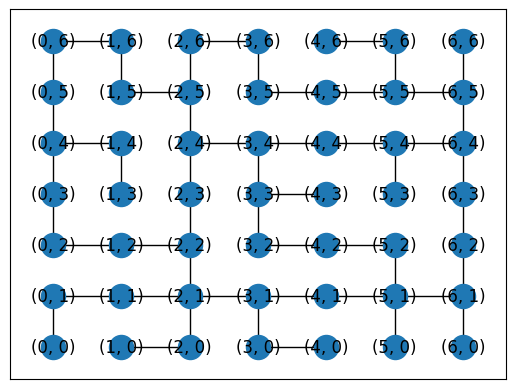

In [6]:
test = get_simple_maze('1')

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot()  # Plot some data on the axes.


#plot_simple_maze_silhouette(test,ax,color='black')

node_coord2node_label = nx.get_node_attributes(test, "label")
node_label2node_coord = {v: k for k, v in node_coord2node_label.items()}
edge_cord2edge_label = nx.get_edge_attributes(test, "label")

position = nx.get_node_attributes(test, "position")

nx.draw_networkx(test,pos=position,ax=ax)

edgePositions = nx.get_edge_attributes(test, "position").values()

data = list(edgePositions)

df = pd.DataFrame(data, columns=['x', 'y'])

array = nx.adjacency_matrix(test).toarray()

array[0,:] #returns the row of the adjacency matrix.

shortestpaths = dict(nx.all_pairs_shortest_path_length(test))

shortestpaths[(0,0)][(1,0)]

Below we draw an adjacency matrix for the maze. Networkx does that very easily.

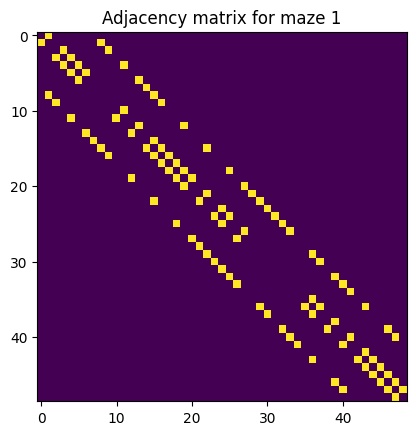

In [7]:

# Plot the adjacency matrix:

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot()  # Plot some data on the axes.

plt.imshow(nx.adjacency_matrix(test).toarray())
plt.title('Adjacency matrix for maze 1')
plt.show()


Based on the above adjacency matrix we try to derive a transition matrix, under the assumption that mice can stand still and that there's an even distribution of probabilities. Recall that an adjacency matrix encodes conditional probabilities between different states $S_i$.

$$ T = \begin{pmatrix}
P(S_1|S_1) &P(S_1|S_2) &\cdots &P(S_1|S_N) \\
P(S_2|S_1) &P(S_2|S_2) &\cdots &P(S_2|S_N) \\
\cdots &\cdots &\cdots &\cdots \\
P(S_N|S_1) &P(S_N|S_2) &\cdots & P(S_N|S_N)
\end{pmatrix} $$

If this distribution is even, we can simply divide by column sum for an adjacency matrix with each node being self-connected.

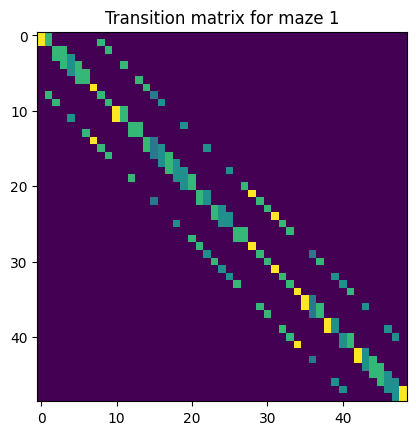

In [8]:
adjacency = nx.adjacency_matrix(test).toarray() #store adjacency in an array

norm_adjacency = adjacency/max(adjacency.flatten()) #normalise so that all adjacency values are 1.

np.fill_diagonal(norm_adjacency,1) #has no output, but makes all diagonals equal to 1, so standing still is a valid transition


t_matrix = adjacency #just initialise by copying data structure
#for c in 0:np.size(adjacency[:][0]) #for each column


for c in range(np.size(adjacency[:][0])): #for each column
 t_matrix[:,c] = norm_adjacency[:,c]/sum(norm_adjacency[:,c]) #make each column a probability over transitions. Remember we index by [row,column].

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot()  # Plot some data on the axes.

plt.imshow(t_matrix)
plt.title('Transition matrix for maze 1')
plt.show()



# Place cells?

Inspired by Stachenfeld et al., 2014, we attempt to map a coarse-grain successor representation of place cells.

The SR should be given by $M=(I - \gamma T)^{-1}$, where $\gamma$ is a discount factor.

The columns of the transition matrix itself should vaguely map onto coarse-scale place cells.

Let's try make that happen.

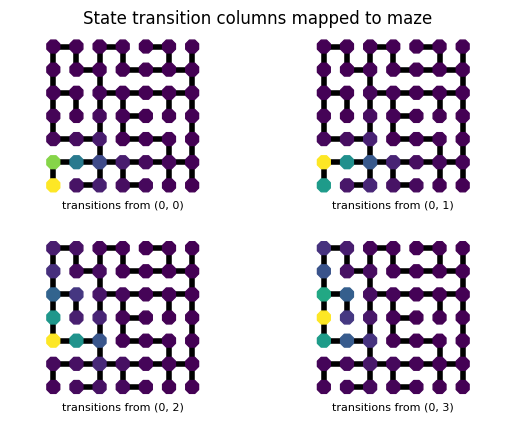

In [21]:
temp_matrix =  np.identity(49)-0.9*t_matrix #(I - gT)^-1, so gamma=0.9
SR_matrix =np.linalg.inv(temp_matrix) #inverse of (I-T)

#To plot a heatmap, we need to have a dictionary of node and edge labels
my_dict = nx.get_node_attributes(test,'label')

# Replace dictionary values with the array
my_dict = dict(zip(my_dict.keys(), t_matrix[:,0]))

my_dict[(0,0)]

#plot_simple_heatmap(test,my_dict,ax) #Let's just skip this function

fig, axs = plt.subplots()   # Create a figure containing a single axes.
plt.title('State transition columns mapped to maze')
axs.axis('off')

for c in range(4):

  ax = fig.add_subplot(2,2,c+1)
  ax.set_aspect('equal')
  ax.axis('off')
  ax.set_title('transitions from ' + str(list(my_dict.keys())[c]), fontsize = 8, y=-0.1) #title the coordinate of the column
  nx.draw_networkx(
        test,
        pos=position,
        ax=ax,
        node_color=SR_matrix[:,c], #Colour according t_matrix
        linewidths=1,
        node_shape="8",
        node_size = 100,
        width=4,
        with_labels=False)

plt.show()

# Grid cells?

Still singing to the tune of Stachenfeld et al., 2014, we will attempt to map the columns of the eigenvectors of the transition matrix to the maze.

NB: Not sure I even understand that myself yet.

We take a very simple approach and consider the eigendecomposition of the transition matrix, mapped onto the maze.

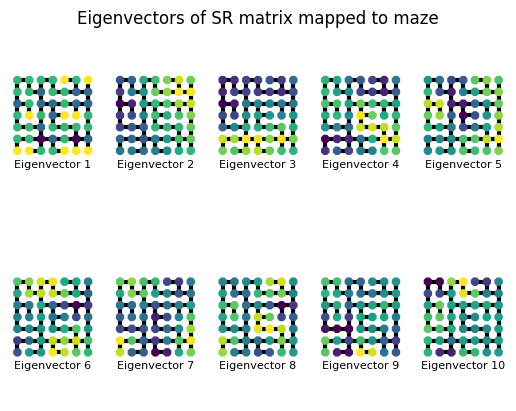

<Figure size 640x480 with 0 Axes>

In [153]:
values, vectors = np.linalg.eig(SR_matrix)

vectors[:,0]

fig, axs = plt.subplots()   # Create a figure
plt.title('Eigenvectors of SR matrix mapped to maze')
axs.axis('off') #remove the axes

for c in range(10):

  ax = fig.add_subplot(2,5,c+1)
  ax.set_aspect('equal')
  ax.axis('off')
  ax.set_title('Eigenvector ' + str(c+1), fontsize = 8, y=-0.2) #title the eigenvector number;
  nx.draw_networkx(
        test,
        pos=position,
        ax=ax,
        node_color=vectors[:,c], #Colour according t_matrix
        linewidths=1,
        node_shape="8",
        node_size = 30,
        width=3,
        with_labels=False)

plt.show()
plt.savefig('SR_eigen_first10.png', dpi=300)

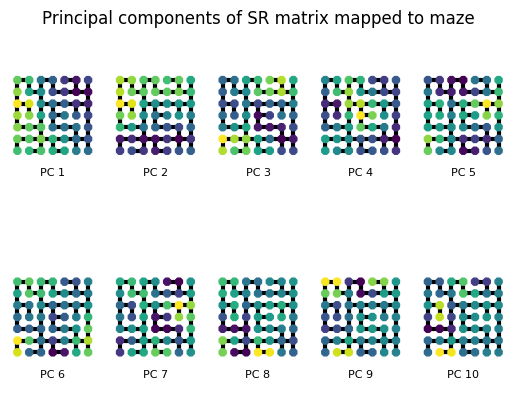

In [11]:

from sklearn.decomposition import PCA

my_n=10

pca_SR = PCA(n_components = my_n)

SR_components = pca_SR.fit_transform(SR_matrix)

principal_SR_Df = pd.DataFrame(data = SR_components,
                               columns = ['0','1','2','3','4','5','6','7','8','9'])


fig, axs = plt.subplots()   # Create a figure
plt.title('Principal components of SR matrix mapped to maze')
axs.axis('off') #remove the axes

for c in range(my_n):

  ax = fig.add_subplot(2,5,c+1)
  ax.set_aspect('equal')
  ax.axis('off')
  ax.set_title('PC ' + str(c+1), fontsize = 8, y=-0.3) #title the eigenvector number;
  nx.draw_networkx(
        test,
        pos=position,
        ax=ax,
        node_color=principal_SR_Df[str(c)], #Colour according t_matrix
        linewidths=1,
        node_shape="8",
        node_size = 30,
        width=3,
        with_labels=False)

plt.show()


In [12]:
pca_SR.explained_variance_ratio_


array([0.14692194, 0.13873402, 0.10655337, 0.08350864, 0.06938741,
       0.05806047, 0.05663768, 0.04627452, 0.03896568, 0.03636182])

# Skeleton section

We want to re-do the above analyses with a finer structure (skeleton maze).

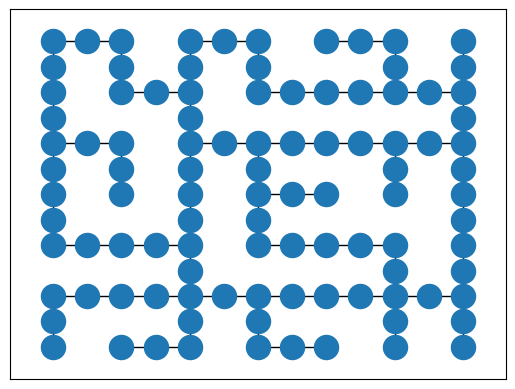

In [13]:
big = get_extended_simple_maze(test)

fig, ax = plt.subplots()

position = nx.get_node_attributes(big, "position")

nx.draw_networkx(big,pos=position,ax=ax,with_labels = False)


In [ ]:
nx.get_node_attributes(big, 'label') #Check how each node is labelled.
#This tells us about the order - the first 49 entries are nodes, and the rest [49+1:end] are edges.

{(0, 0): 'A1',
 (0, 1): 'A2',
 (0, 2): 'A3',
 (0, 3): 'A4',
 (0, 4): 'A5',
 (0, 5): 'A6',
 (0, 6): 'A7',
 (1, 0): 'B1',
 (1, 1): 'B2',
 (1, 2): 'B3',
 (1, 3): 'B4',
 (1, 4): 'B5',
 (1, 5): 'B6',
 (1, 6): 'B7',
 (2, 0): 'C1',
 (2, 1): 'C2',
 (2, 2): 'C3',
 (2, 3): 'C4',
 (2, 4): 'C5',
 (2, 5): 'C6',
 (2, 6): 'C7',
 (3, 0): 'D1',
 (3, 1): 'D2',
 (3, 2): 'D3',
 (3, 3): 'D4',
 (3, 4): 'D5',
 (3, 5): 'D6',
 (3, 6): 'D7',
 (4, 0): 'E1',
 (4, 1): 'E2',
 (4, 2): 'E3',
 (4, 3): 'E4',
 (4, 4): 'E5',
 (4, 5): 'E6',
 (4, 6): 'E7',
 (5, 0): 'F1',
 (5, 1): 'F2',
 (5, 2): 'F3',
 (5, 3): 'F4',
 (5, 4): 'F5',
 (5, 5): 'F6',
 (5, 6): 'F7',
 (6, 0): 'G1',
 (6, 1): 'G2',
 (6, 2): 'G3',
 (6, 3): 'G4',
 (6, 4): 'G5',
 (6, 5): 'G6',
 (6, 6): 'G7',
 ((0, 0), (0, 1)): 'A1-A2',
 ((1, 0), (2, 0)): 'B1-C1',
 ((1, 3), (1, 4)): 'B4-B5',
 ((3, 0), (4, 0)): 'D1-E1',
 ((3, 3), (4, 3)): 'D4-E4',
 ((4, 6), (5, 6)): 'E7-F7',
 ((5, 0), (5, 1)): 'F1-F2',
 ((5, 3), (5, 4)): 'F4-F5',
 ((6, 0), (6, 1)): 'G1-G2',
 ((6, 5), (6,

## Compute SR matrix

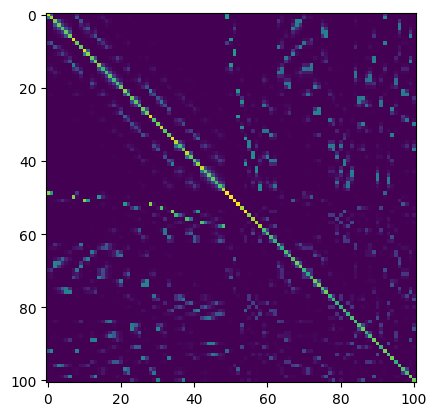

In [22]:
adjacency = nx.adjacency_matrix(big).toarray() #store adjacency in an array

norm_adjacency = adjacency/max(adjacency.flatten()) #normalise so that all adjacency values are 1.


np.fill_diagonal(norm_adjacency,1) #has no output, but makes all diagonals equal to 1, so standing still is a valid transition

plt.imshow(norm_adjacency)



for c in range(np.size(adjacency[:][0])): #for each column
 norm_adjacency[:,c] = norm_adjacency[:,c]/sum(norm_adjacency[:,c]) #make each column a probability over transitions. Remember we index by [row,column].

Transition = norm_adjacency #just initialise by copying data structure
#for c in 0:np.size(adjacency[:][0]) #for each column

temp_matrix =  np.identity(np.linalg.matrix_rank(Transition))-0.9*Transition #(I - gT)^-1, so gamma=0.9
bigSR =np.linalg.inv(temp_matrix)

plt.imshow(bigSR)

ValueError: Invalid RGBA argument: 0.02

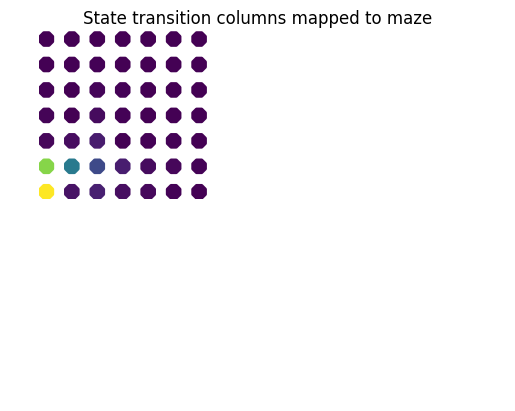

In [46]:
fig, axs = plt.subplots()   # Create a figure containing a single axes.
plt.title('State transition columns mapped to maze')
axs.axis('off')

for k in range(4):

  ax = fig.add_subplot(2,2,c+1)
  ax.set_aspect('equal')
  ax.axis('off')
  nx.draw_networkx(
        test,
        pos=position,
        ax=ax,
        node_color=SR_matrix[0:49,k], #Colour according t_matrix
        edge_color=np.ceil(bigSR[50:101,k]* 1000.0) / 1000.0,
        linewidths=2,
        node_shape="8",
        node_size = 100,
        width=4,
        with_labels=False)

plt.show()




In [88]:
place_values = pd.read_parquet('cluster.navigationPlaceRates.parquet')

place_values

test = get_simple_maze('1')

variable = place_values.iloc[1]

variable.index.name = 'maze_position'

print(variable)


maze_position
A1            NaN
A1-A2    0.000000
A2       2.882348
A2-B2    2.933678
A3       3.300972
           ...   
G5       3.835061
G5-G6    3.779527
G6       3.875126
G6-G7    9.133432
G7       3.990621
Name: m2_2022-07-05_095337_cluster1, Length: 101, dtype: float64


## Eigendecomposition


In [172]:
from sklearn.decomposition import PCA

my_n=25

pca_SR = PCA(n_components = my_n)

SR_components = pca_SR.fit_transform(bigSR)

varExp = np.ceil(pca_SR.explained_variance_ratio_*1000)/10

varExp

array([7.2, 7.1, 6.5, 6. , 5.6, 5.2, 5.2, 4.8, 4.4, 4.3, 3.7, 3.5, 3.3,
       2.7, 2.5, 2.3, 2.2, 2. , 1.8, 1.6, 1.5, 1.2, 1.1, 1.1, 1.1])

## Plotting

<Figure size 3000x3000 with 0 Axes>

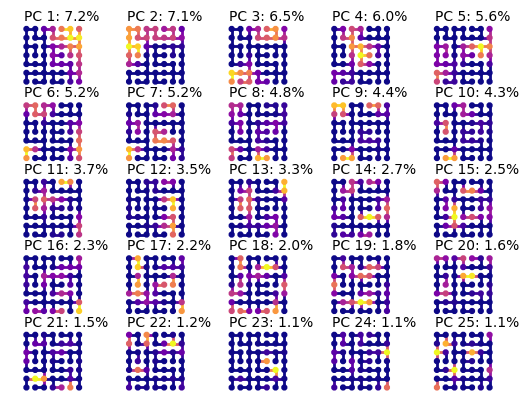

In [174]:

label = nx.get_node_attributes(big, 'label').values()
plt.figure(figsize=(10, 10), dpi=300)

fig, axs = plt.subplots()
axs.axis('off')

for c in range(my_n):
  ax = fig.add_subplot(5,5,c+1)
  ax.set_aspect('equal')
  ax.axis('off')
  value = SR_components[:,c]

  values = pd.Series(data=value, index=label)

  values.index.name='maze_position'

  plot_simple_heatmap(test, values, ax, node_size = 10, edge_size = 2, value_label='', title='PC '+str(c+1)+': '+str(varExp[c])+'%')